# **Sentiment Mining with Pinecone**

In [3]:
! pip install sentence_transformers pinecone-client datasets seaborn matplotlib

# **Load and Prepare Dataset**

In [4]:
from datasets import load_dataset

In [5]:
df = load_dataset('ashraq/hotel-reviews',split='train').to_pandas()

README.md:   0%|          | 0.00/548 [00:00<?, ?B/s]

(…)-00000-of-00001-d30d4a38ef4cc157.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/93757 [00:00<?, ? examples/s]

In [6]:
df

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...
...,...,...,...
93752,8/4/2015,Holiday Inn London Kensington,Loved the location friendly helpful staff
93753,8/4/2015,Holiday Inn London Kensington,The room wasn t what was described on website...
93754,8/4/2015,Holiday Inn London Kensington,Location was good
93755,8/4/2015,Holiday Inn London Kensington,Bed room service was very late


In [7]:
# we keep only the first 800 characters of each review
df["review"] = df['review'].str[:800]
df.head()

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


# **Initializing the sentiment model**

In [8]:
import torch

In [9]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from transformers import pipeline,AutoTokenizer,AutoModelForSequenceClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [12]:
# loading the sentiment analysis model 
model_id = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                          num_labels=3)
# loading the tokenizer from Huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)
# loading both the model and the tokenizer into the sentiment analysis pipeline
nlp = pipeline("sentiment-analysis",
               model=model,
              tokenizer=tokenizer,
              device = device)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [13]:
labels = {
    'LABEL_0':'negative',
    'LABEL_1':'neutral',
    'LABEL_2':'positive'
}

In [14]:
test = df['review'][241]
test

' Room was small for a superior room and poorly lit especially as it was an inside room and overlooked the inside wall of the hotel No view therefore needed better lighting within Restaurant tables were not well laid and had to go searching for cutlery at breakfast '

In [15]:
# applying the nlp model
nlp(test)

[{'label': 'LABEL_0', 'score': 0.7736574411392212}]

# **initalizing the retrievel model** 

In [16]:
from sentence_transformers import SentenceTransformer

In [17]:
# loading the model from hugging face
retriever = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2',
                              device=device)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# **Initializing the Pinecone Index**

In [18]:
!pip uninstall -y pinecone-client

Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0


In [19]:
! pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 8.7 MB/s eta 0:00:00:00:01


In [20]:
key = "pcsk_5VXdpR_UaDYWRTemDNVZh8SUz9wQSTuT2rGSZnNwStFmm6XRtMUurb1wAuyUxMDxhzpzki"

In [21]:
import pinecone
from pinecone import Pinecone

# **sentiment-analysis-vector** 

In [22]:
from pinecone import Pinecone, ServerlessSpec

from pinecone import Pinecone

pc = Pinecone(api_key=key)
index = pc.Index("sentiment-analysis-vector")


In [23]:
def get_sentiment(reviews):
    sentiments = nlp(reviews)
    i = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return i , s 

In [24]:
get_sentiment(df['review'][:10].tolist())

(['negative',
  'neutral',
  'positive',
  'neutral',
  'positive',
  'neutral',
  'positive',
  'negative',
  'positive',
  'negative'],
 [0.9065250754356384,
  0.7716172933578491,
  0.8975034952163696,
  0.6135808229446411,
  0.9900740385055542,
  0.6364567875862122,
  0.9828112125396729,
  0.9010939598083496,
  0.9400402307510376,
  0.9517661333084106])

In [25]:
df.dtypes

review_date    object
hotel_name     object
review         object
dtype: object

In [26]:
import dateutil.parser

In [27]:
def get_timestamp(dates):
    timestamp = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamp

In [28]:
get_timestamp([df["review_date"][0]])[0]

1501718400.0

In [29]:
from tqdm.auto import tqdm

batch_size = 64

for i in tqdm(range(0, 64*50, batch_size), desc="Processing batches"):
    try:
        # Define batch range
        i_end = min(i + batch_size, 64*20)
        batch = df.iloc[i:i_end]

        # Encode reviews into embeddings
        emb = retriever.encode(batch["review"].tolist()).tolist()

        # Get timestamps and sentiment analysis
        timestamp = get_timestamp(batch['review_date'].tolist())
        label, score = get_sentiment(batch['review'].tolist())
        
        # Add new data to batch
        batch['label'], batch['score'] = label, score

        # Prepare metadata and IDs
        meta = batch.to_dict(orient="records")
        ids = [str(idx) for idx in range(i, i_end)]

        # Prepare data for upsert and push to index
        to_upsert = list(zip(ids, emb, meta))
        _ = index.upsert(vectors=to_upsert)

    except Exception as e:
        print(f"❗ Error processing batch {i // batch_size + 1}: {e}")

# Display index stats after all batches
stats = index.describe_index_stats()
print("✅ Index stats:", stats)


Processing batches:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches: 0it [00:00, ?it/s]

❗ Error processing batch 21: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '4780428461581855057', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 22: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '1638327032420664000', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 23: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '20', 'x-pinecone-request-id': '5901219619165446168', 'x-envoy-upstream-service-time': '21', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 24: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '3482991303181370050', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 25: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '172346967498346725', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 26: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '2088334062075110109', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 27: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '8934355842126511978', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 28: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '8438283834934581924', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 29: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '8546435324689000538', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 30: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '567563650456876463', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 31: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '8632273668538109592', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 32: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '3597976105494855382', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 33: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '7996323387247423885', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 34: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '7005526131690960583', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 35: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '3233283859886699100', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 36: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '5607376395340303107', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 37: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '7159560847812467291', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 38: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '3272152659884906451', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 39: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '4250467142679838844', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 40: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '4527149336584065911', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 41: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '7034020671449101261', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 42: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '1751760119282575379', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 43: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '980881344814256115', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 44: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '4314533913102491780', 'x-envoy-upstream-service-time': '1', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 45: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '7107471891789028279', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 46: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '1444615261973328706', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 47: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '8757911315049078242', 'x-envoy-upstream-service-time': '1', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 48: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '7384452128704173963', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 49: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '5393548742207288410', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}



Batches: 0it [00:00, ?it/s]

❗ Error processing batch 50: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 17 Mar 2025 15:44:38 GMT', 'Content-Type': 'application/json', 'Content-Length': '52', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '0', 'x-pinecone-request-id': '6738184020002893598', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":3,"message":"Invalid request.","details":[]}

✅ Index stats: {'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 4416}},
 'total_vector_count': 4416,
 'vector_type': 'dense'}


# **Room size and satisfaction`RSS`**

In [30]:
query = "are customers satisfied with the room sizees of hotels in london ?"
xq = retriever.encode(query).tolist()

result = index.query(
    vector=xq, top_k=1000,
    include_metadata = True,
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
data = result['matches']

In [32]:
import pandas as pd 

In [33]:
RSS_data = pd.DataFrame([
    {
        'id': r['id'],
        'similarity_score': r['score'],
        'hotel_name': r['metadata']['hotel_name'],
        'label': r['metadata']['label'],
        'review': r['metadata']['review'],
        'review_date': r['metadata']['review_date'],
        'sentiment_score': r['metadata']['score']
    }
    for r in data
])

In [34]:
RSS_data.head()

,id,similarity_score,hotel_name,label,review,review_date,sentiment_score
0,1950,0.813276,Park Plaza County Hall London,positive,Was a good size room considering it s a Londo...,6/12/2017,0.897906
1,3794,0.735931,Grand Royale London Hyde Park,neutral,Hotel was relying on its location undeniably ...,7/22/2017,0.448455
2,4179,0.722367,Grand Royale London Hyde Park,neutral,The rooms are very small if your used to big ...,3/21/2017,0.502508
3,1044,0.715673,Park Plaza County Hall London,positive,A really lovely hotel close to the London Eye...,8/28/2016,0.988469
4,383,0.713138,Park Plaza County Hall London,positive,The room was exceedingly comfortable very ver...,4/5/2017,0.977194


In [35]:
import seaborn as sns 

<Axes: xlabel='label', ylabel='count'>

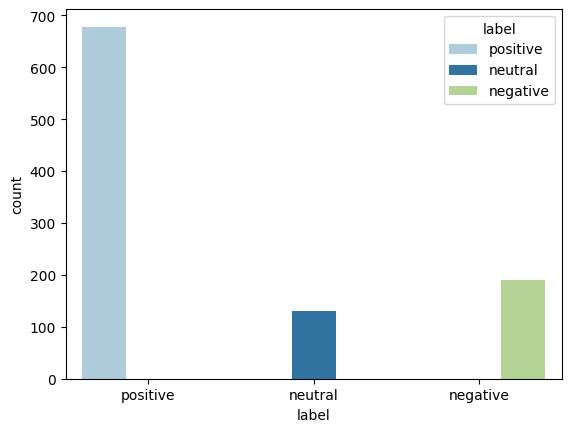

In [36]:
sns.countplot(RSS_data,x='label',hue='label',palette='Paired')

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, '')

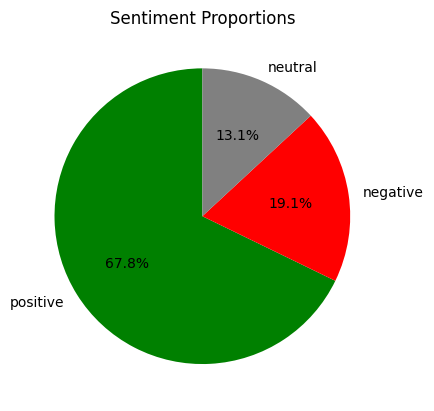

In [40]:
sentiment_count = RSS_data['label'].value_counts()
sentiment_count.plot(kind='pie',autopct='%1.1F%%',startangle=90,colors=['green','red','gray'])
plt.title('Sentiment Proportions')
plt.ylabel('')

In [51]:
sentiment_count.index

Index(['positive', 'negative', 'neutral'], dtype='object', name='label')

In [79]:
hotel_names = RSS_data['hotel_name'].unique()
hotel_names

array(['Park Plaza County Hall London', 'Grand Royale London Hyde Park'],
      dtype=object)

In [ ]:
pip install nltk wordcloud

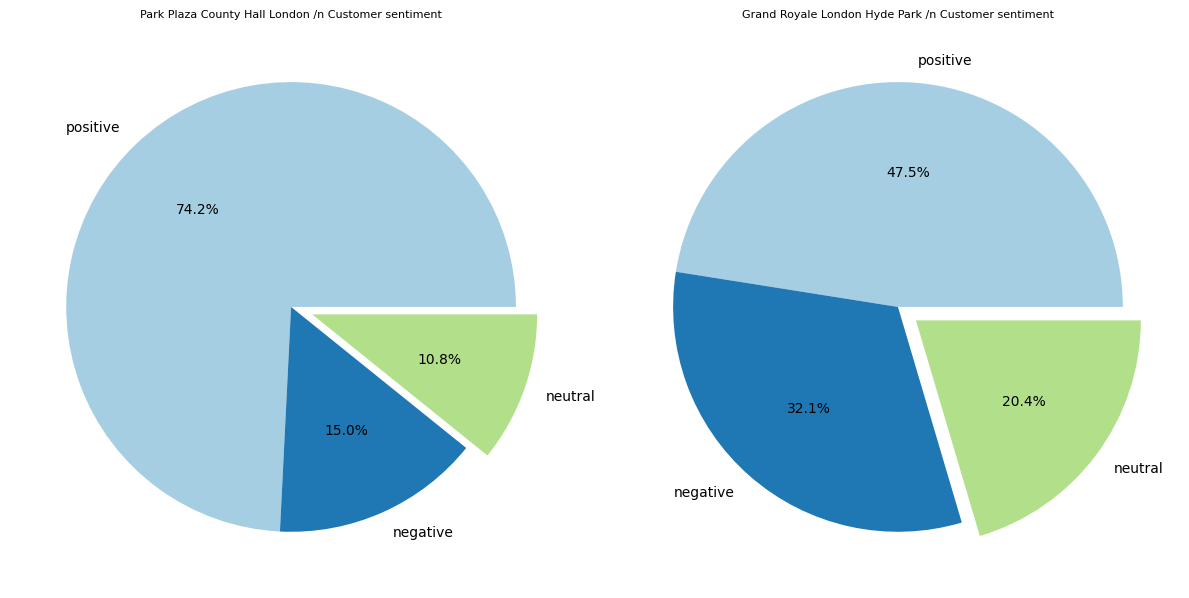

In [81]:
explode = [0,0,0.1]
palette_color = sns.color_palette('Paired') 
fig , ax = plt.subplots(1,2,figsize=(12,6))
for i,hotel in enumerate (hotel_names):
    sentiment_count = RSS_data[RSS_data['hotel_name']==hotel]['label'].value_counts()
    ax[i].pie(sentiment_count ,labels = sentiment_count.index , colors = palette_color,explode=explode,autopct = '%1.1F%%')
    ax[i].set_title(f'{hotel} /n Customer sentiment',size=8)
plt.tight_layout()    
    

In [42]:
import nltk
import string
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [41]:
from nltk.corpus import stopwords

In [43]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [44]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('','',string.punctuation)).lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

In [45]:
RSS_data['review']=RSS_data['review'].apply(clean_text)

In [46]:
pos_RSS_reviews = " ".join(RSS_data[RSS_data['label']=='positive']['review'])
neg_RSS_reviews = " ".join(RSS_data[RSS_data['label']=='negative']['review'])

In [47]:
pos_word_cloud = WordCloud(
    stopwords =set(stopwords.words('english')),
    width = 800 , height=400, background_color = 'white',colormap='Blues'
).generate(pos_RSS_reviews)

neg_word_cloud = WordCloud(
    stopwords =set(stopwords.words('english')),
    width = 800 , height=400, background_color = 'white',colormap='inferno'
).generate(neg_RSS_reviews)

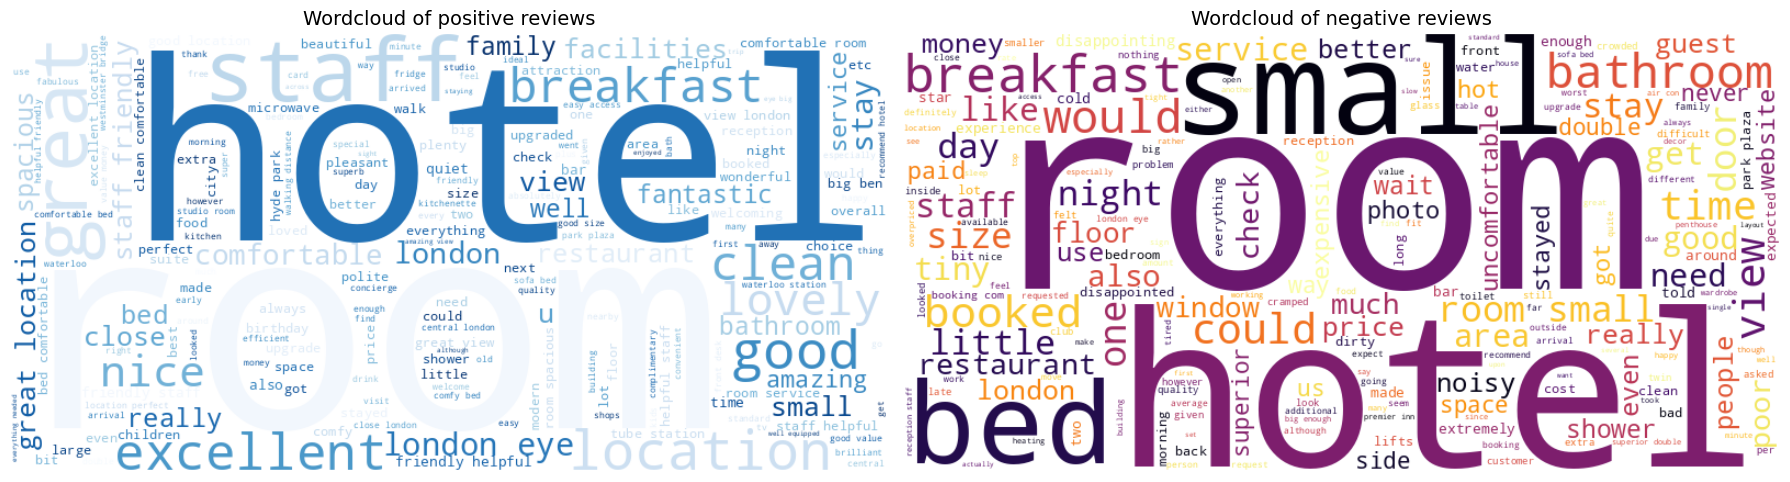

In [48]:
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.imshow(pos_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of positive reviews',size=14)
plt.subplot(1,2,2)
plt.imshow(neg_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of negative reviews',size=14)


plt.tight_layout()
plt.show()

# **sentiment overview**

In [ ]:
queries = [{"food_Quality":"are customers satisfied with the food Quality","are Customers satisfied with the stuff?",""}]
for q in queries
xq = retriever.encode(query).tolist()

result = index.query(
    vector=xq, top_k=1000,
    include_metadata = True,
)